In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
left = []
right = []

with open('motion_gui_logs_rachel_1.pickle', 'rb') as f:
    file = pickle.load(f)
    
    event_array = file['EVENT_LOG']
    signal_array = file['DATA_LOG']
    
    j = 0
    for i in tqdm(range(len(event_array)-1)):
        
        event_data = vars(event_array[i])
        next_event_data = vars(event_array[i+1])
        
        # initial time for that event
        time_0 = event_data['timestamp']
        
        # array to store signal for that event
        event_signal = np.array([])
        
        # loop through signal array. While timestamp is less than timestamp
        # of the next event, add it to the current event signal
        while signal_array[j]['time'] <= next_event_data['timestamp']:
            
            # number of points at that timestamp
            n_samples = signal_array[j]['data'].shape[1]
            
            # spread out time between this timestamp and the next
            times = np.linspace(signal_array[j]['time'], signal_array[j+1]['time'], n_samples)
            
            # map each time to a list of channel values
            for time, channel_values in zip(times, signal_array[j]['data'][:8].T):

                # signal at this event timestamp
                signal_at_time = np.array([])

                # populate the current signal array
                for channel in channel_values:
                    point = np.array([time - time_0, channel])
                    signal_at_time = np.vstack((signal_at_time, point)) \
                                            if signal_at_time.size else point
                    
                # add another dimension to signal_at_time for formatting
                signal_at_time = np.expand_dims(signal_at_time, axis=1)
                    
                # add the signal at the current time to the event signal
                event_signal = np.concatenate((event_signal, signal_at_time), axis=1) \
                                            if event_signal.size else signal_at_time
            
            # next timestamp in signal array
            j += 1
            
        # add it to either left or right data
        if event_signal.size == 0:
            continue
  
        if event_data['task'] == 'LEFT':
            left.append(event_signal)
                
        elif event_data['task'] == 'RIGHT':
            right.append(event_signal)
                
    # add remaining not needed since last event is end


100%|█████████████████████████████████████████| 184/184 [00:06<00:00, 27.81it/s]


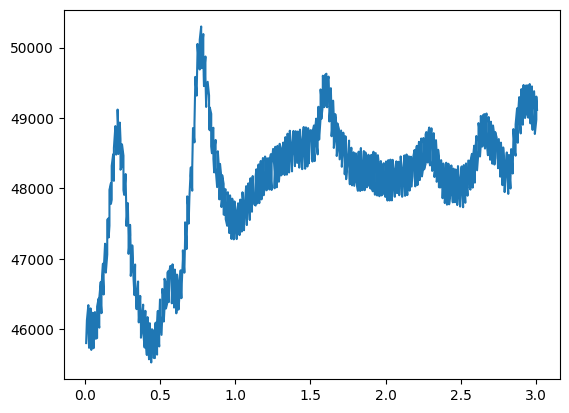

In [3]:
# format: left[event_number][channel_number][time] = [time, value]
plt.plot(left[3][4][:, 0], left[3][4][:, 1])

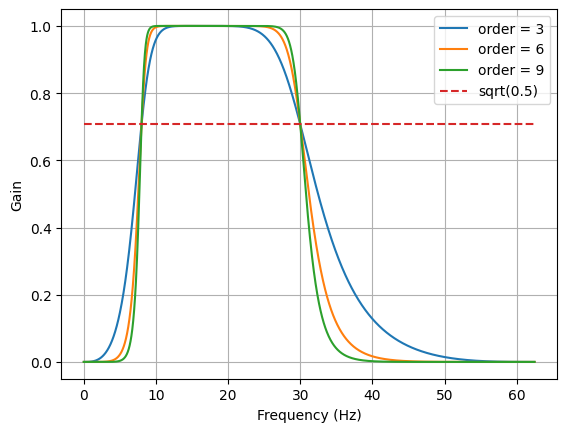

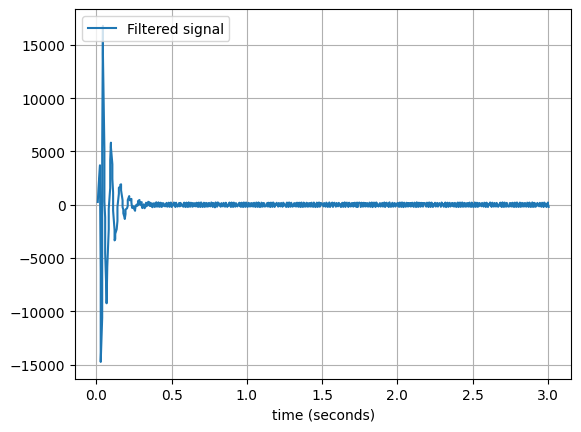

In [4]:
# Butterworth Bandpass Filter
# Taken from https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 125
lowcut = 8
highcut = 30

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Let's extract a single channel from a single event
t = left[3][4][:, 0]
x = left[3][4][:, 1]

# Filter the signal
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

plt.figure()
plt.plot(t, y, label='Filtered signal')
plt.xlabel('time (seconds)')
# plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

# # Filter a noisy signal.
# T = 0.05
# nsamples = T * fs
# t = np.arange(0, nsamples) / fs
# a = 0.02
# f0 = 600.0
# x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
# x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
# x += a * np.cos(2 * np.pi * f0 * t + .11)
# x += 0.03 * np.cos(2 * np.pi * 2000 * t)
# plt.figure(2)
# plt.clf()
# plt.plot(t, x, label='Noisy signal')

# y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
# plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
# plt.xlabel('time (seconds)')
# plt.hlines([-a, a], 0, T, linestyles='--')
# plt.grid(True)
# plt.axis('tight')
# plt.legend(loc='upper left')

plt.show()

In [5]:
# Wavelet Packet Transform
# TODO: figure out how to filter specific frequencies. currently we're just taking the lower 50% of frequencies
# maybe this: https://stackoverflow.com/questions/54619107/how-to-combine-wavelet-transform-and-frequency-filtering
# or this: https://stackoverflow.com/questions/6493796/eeg-wavelet-analysis?rq=1

import pywt

wp = pywt.WaveletPacket(data=y, wavelet='db4', mode='symmetric')

In [6]:
# not really sure, but i think this means each node at the 5th level corresponds to data in 15hz bins
# We want Mu (8-14 Hz) and Beta (15-30 Hz)
# To get beta do we just take the 2nd bin at the 5th level?

# https://www.researchgate.net/post/How-can-we-calculate-the-frequency-band-for-a-DWT-detailed-coefficients

coeffs = pywt.wavedec(y, 'db4', level=5)
print(pywt.scale2frequency('db4',5)*125) # sampling frequency is 125 Hz

coeffs

17.857142857142858


[array([-2.47285957e+03, -2.51589241e+03, -2.74043617e+03, -2.44543278e+03,
        -3.01584323e+03, -7.43421443e+02,  5.82782474e+01, -8.82241290e+00,
        -1.38255720e+00,  2.98836643e-01, -6.68886617e-01,  3.12171043e-01,
         2.67307486e-01, -6.32680110e-01,  6.67096977e-01, -3.43737186e-01,
        -1.11371620e-01,  4.52726958e-01, -6.12813230e-01,  5.15306522e-01,
        -1.53722095e-01, -2.14317741e-01,  3.16982024e-01, -3.27373567e-01,
         2.86244766e-01,  7.97864208e-01, -1.01851102e+01,  5.29542617e+01,
        -1.91966292e+02, -3.00272876e+02]),
 array([ 2.02701068e+02,  4.68978651e+02, -9.39922369e+02,  5.42343680e+02,
        -1.37999476e+02,  5.42400488e+01, -2.42102980e+00,  2.24358160e+00,
        -1.82986853e+00, -1.20689570e+00,  1.01721460e+00, -1.22626828e-01,
         5.78969682e-01,  1.38665631e+00, -2.00203166e+00, -1.22459830e+00,
        -1.34833470e+00, -2.03893370e+00,  8.64224185e-01, -1.33391688e+00,
        -5.35054986e-01,  1.71706550e-01,  1

In [7]:
wp['aaaaa'].data

array([-2.47285957e+03, -2.51589241e+03, -2.74043617e+03, -2.44543278e+03,
       -3.01584323e+03, -7.43421443e+02,  5.82782474e+01, -8.82241290e+00,
       -1.38255720e+00,  2.98836643e-01, -6.68886617e-01,  3.12171043e-01,
        2.67307486e-01, -6.32680110e-01,  6.67096977e-01, -3.43737186e-01,
       -1.11371620e-01,  4.52726958e-01, -6.12813230e-01,  5.15306522e-01,
       -1.53722095e-01, -2.14317741e-01,  3.16982024e-01, -3.27373567e-01,
        2.86244766e-01,  7.97864208e-01, -1.01851102e+01,  5.29542617e+01,
       -1.91966292e+02, -3.00272876e+02])

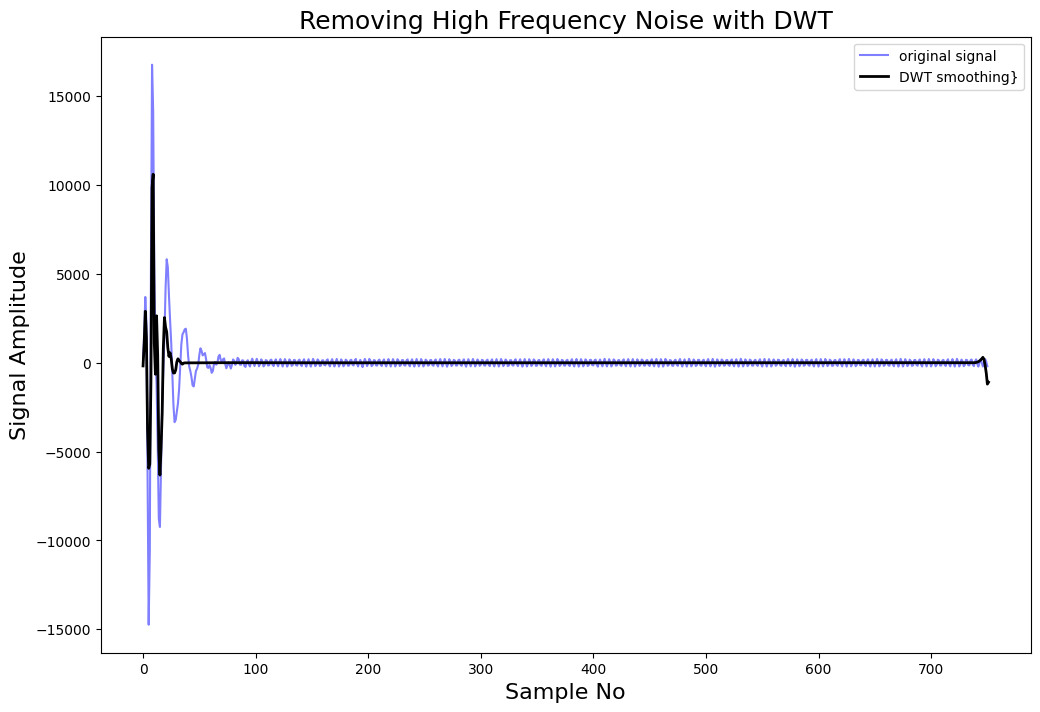

In [8]:
signal = y

def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [9]:
# The rest of this code is just taken from https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
# but it looks like it works?

from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [10]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')
    
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

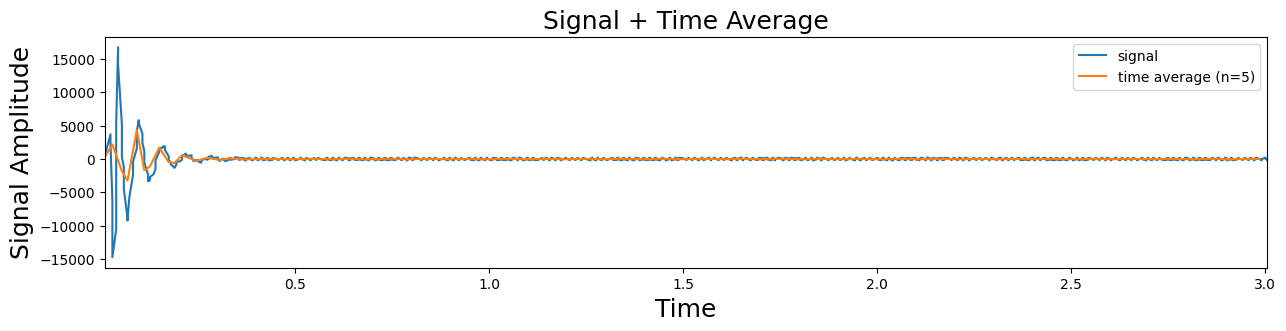

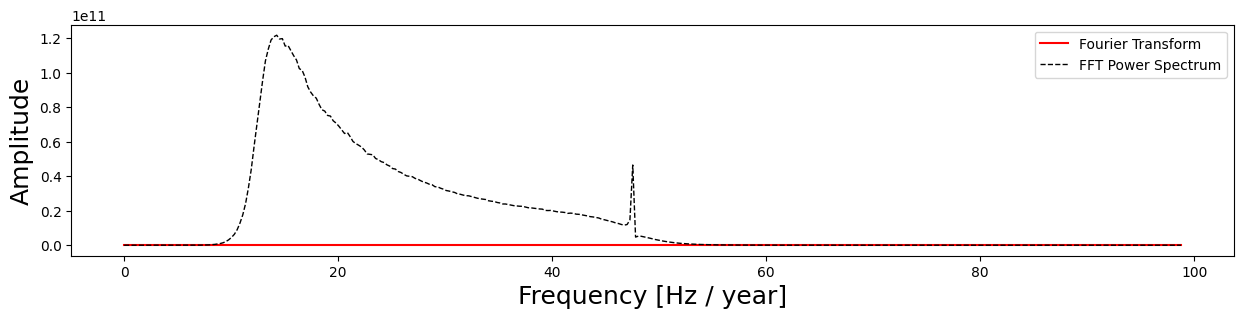

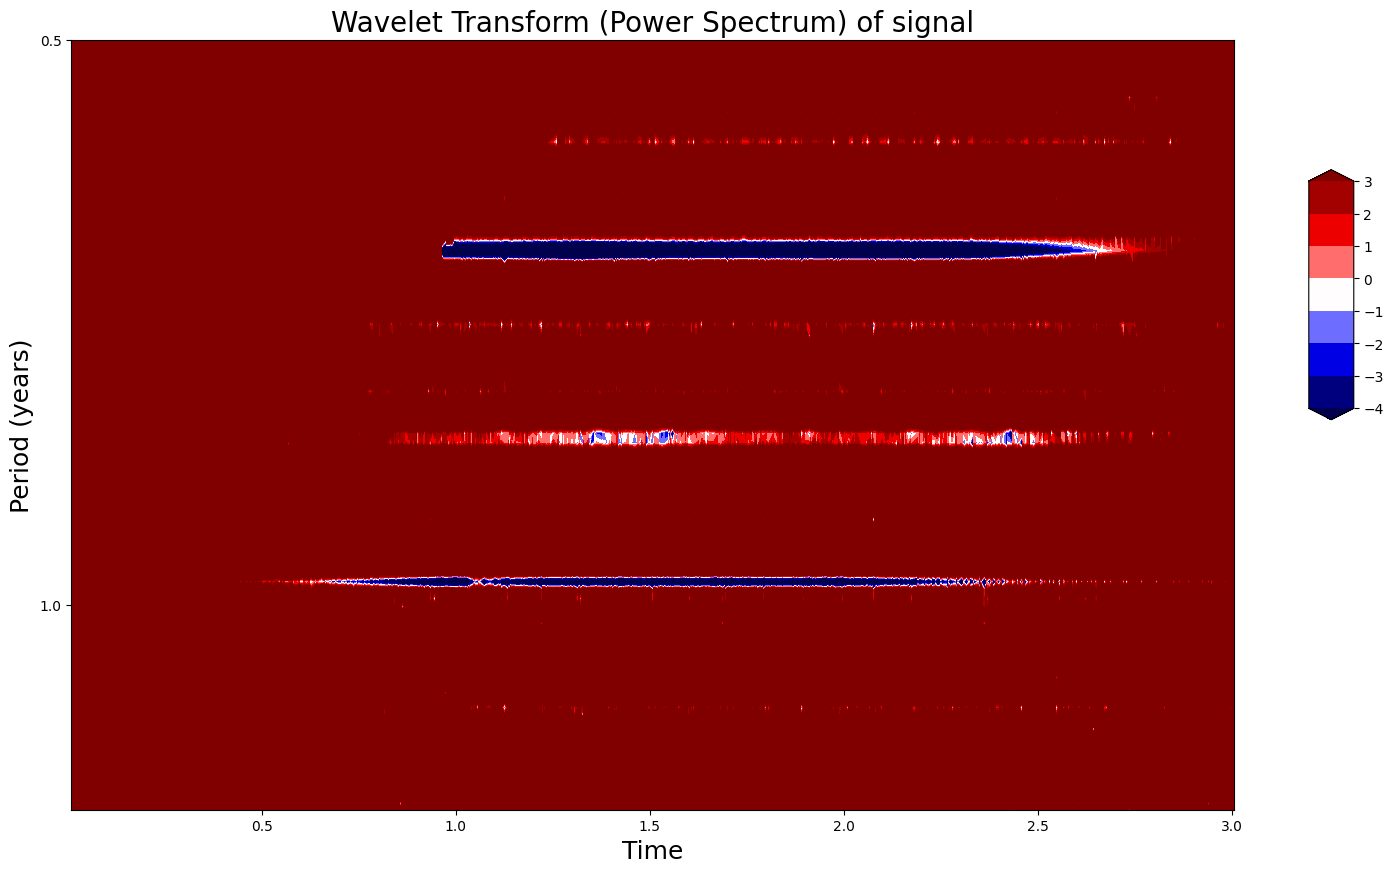

In [14]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
 
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
 
time = t
signal = y # rec[:-1] # extra value for some reason
    
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)